# Test metrics
**See chapter "Own implementaion" for final result**

### Configuration

In [1]:
LOG_2_TENSORBOARD = False  # True: write accuracy and loss statistics to tensorboard
RUN_ON_KAGGLE = False  # True: Only Colab ready code will be processed
DO_GOOGLE_BACKTRANSLATION = False

SAVE_GRU_MODEL = False
RUN_GRU_MODEL = True  # True: run prediction, save model during training if SAVE_GRU_MODEL = True
TRAIN_GRU_MODEL = True  # True: train and save model

GRU_MODEL_FNAME = "GRU_Translator_256_20210427-162007.hd5"

DEBUG = False
SEED = 42

EARLY_STOPPING_PATIENCE = 3
MEMORY_OF_GPU = 10000  # MBytes
MEMORY_OF_GPU = 6000  # MBytes

TENSORBOARD_LOGDIR = logdir = "./tensorboard_logs/scalars/"
FILE_DIR = "../data/raw/"
MODEL_DIR = "../data/interim/"

### Setup


In [2]:
# You may want to upgrade the tensorflow package to the latest verion (currently version 2.3) if you have the proper infrastructure
if RUN_ON_KAGGLE:
    !pip install --upgrade tensorflow
    !pip install tqdm
    !pip install google_trans_new
    !pip install pycocoevalcap
    !pip install tensorflow-addons

In [3]:
import io
import pandas as pd
import numpy as np
from typing import List 

import tensorflow as tf
import tensorflow.keras.callbacks as kaba
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, LSTM
from tensorflow.keras.layers import Embedding, RepeatVector, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy, categorical_crossentropy

import src.models.metrics_experimental as met_exp
import src.models.metrics as met

import collections
import tqdm
import datetime as dt
import time
import google_trans_new
import sklearn
import sklearn.metrics as skme
import sklearn.model_selection as skms

import warnings
warnings.simplefilter(action='ignore')

pd.set_option('display.max_colwidth', None)
gtranse = google_trans_new.google_translator()

/home/ths/miniconda3/envs/aida/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ths/miniconda3/envs/aida/lib/python3.7/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [4]:
# To get access to a GPU instance you can use the `change runtime type` and set the option to `GPU` from the `Runtime` tab  in the notebook
# Checking the GPU availability for the notebook
#tf.test.gpu_device_name()

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Create virtual GPUs
    try:
        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],
        )

        tf.config.experimental.set_virtual_device_configuration(
            #OK, but solwer: 
            #gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024),
            #      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2.5*1024)],
            #OK 
            gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=MEMORY_OF_GPU//2)],
            #Error using NCCL automatically on mirrored strategy: gpus[1], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10*1024)],            
        )
    except:
        # Virtual devices must be set before GPUs have been initialized
        print("Warning: During GPU handling.")
        pass
    finally:
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs\n")

# Set runtime context and batch size
l_rtc_names = [
    "multi-GPU_MirroredStrategy",
    "multi-GPU_CentralStorageStrategy",
    "1-GPU",
    "CPUs",
    "multi-GPU_MirroredStrategy_NCCL-All-Reduced",
]
l_rtc = [
    tf.distribute.MirroredStrategy().scope(),
    tf.distribute.experimental.CentralStorageStrategy().scope(),
    tf.device("/GPU:0"),
    tf.device("/CPU:0"),
    tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.NcclAllReduce()).scope(),
]
if len(gpus) == 0:
    rtc_idx = 3
    batch_size = 64

elif len(gpus) == 1:
    rtc_idx = 2
    batch_size = 4*256

elif len(gpus) > 1:
    rtc_idx = 0
    batch_size = 8*256

# DELME
#rtc_idx = 3

runtime_context = l_rtc[rtc_idx]

print(f"\nRuntime Context: {l_rtc_names[rtc_idx]}")
print(f"Batch Size: {batch_size} datasets")

1 Physical GPU, 2 Logical GPUs

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1'], variable_device = '/device:CPU:0'
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Runtime Context: 1-GPU
Batch Size: 1024 datasets


### Loading and Preprocessing of the Data

#### Reading CSV data files as a list of strings, where each string represents a single line from the text


In [5]:
import csv
from io import TextIOWrapper
from zipfile import ZipFile

In [6]:
with ZipFile(FILE_DIR + 'small_vocab_en.csv.zip') as zf:
    with zf.open('small_vocab_en.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        english_text = [item for sublist in reader for item in sublist]
        print(f"English text samples: {english_text[0:2]}")

English text samples: ['new jersey is sometimes quiet during autumn , and it is snowy in april .', 'the united states is usually chilly during july , and it is usually freezing in november .']


In [7]:
with ZipFile(FILE_DIR + 'small_vocab_fr.csv.zip') as zf:
    with zf.open('small_vocab_fr.csv', 'r') as infile:
        reader = csv.reader(TextIOWrapper(infile, 'utf-8'), delimiter='\n' )
        french_text = [item for sublist in reader for item in sublist]
        print(f"French translation text samples: {french_text[0:2]}")

French translation text samples: ["new jersey est parfois calme pendant l' automne , et il est neigeux en avril .", 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .']


### TODO: Data exploration -> calculate and print some statistics on data

In [8]:
# Load text to dataframes
df_en = pd.DataFrame(data=english_text, columns=["text"], dtype=str)
df_fr = pd.DataFrame(data=french_text, columns=["text"], dtype=str)

# Show statistics
print("English Text")
print("============")
display(df_en.info())
display(df_en.describe())
print(f"Max. sentence length: {max(df_en.text.str.len())}")
print(f"Min. sentence length: {min(df_en.text.str.len())}")
results_en = collections.Counter()
df_en.text.str.replace("[^a-zA-z ]", "").str.split(" ").apply(results_en.update)
print(f"Number of words: {len(results_en.keys())}")
english_text_unique = set(english_text)
print(f"Number of duplicated sentences: {len(english_text) - len(english_text_unique)}")

English Text
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


None

,text
count,137860
unique,129174
top,he dislikes bananas and oranges .
freq,3


Max. sentence length: 102
Min. sentence length: 13
Number of words: 200
Number of duplicated sentences: 8686


In [9]:
print("\nFrench Text")
print("=============")
display(df_fr.info())
display(df_fr.describe())
print(f"Max. sentence length: {max(df_fr.text.str.len())}")
print(f"Min. sentence length: {min(df_fr.text.str.len())}")
results_fr = collections.Counter()
df_fr.text.str.replace("[^a-zA-z ]", "").str.split(" ").apply(results_fr.update)
print(f"Number of unique words: {len(results_fr.keys())}")
# check doubled english sentences
french_text_unique = set(french_text)
print(f"Number of duplicated sentences: {len(french_text) - len(french_text_unique)}")


French Text
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


None

,text
count,137860
unique,120806
top,"elle aime les bananes , les mangues et citrons verts ."
freq,6


Max. sentence length: 114
Min. sentence length: 13
Number of unique words: 340
Number of duplicated sentences: 17054


#### Tokenizing the data

Since the input data to neural networks needs to be in numerical format, we first turn each sentence into a sequence of word ids using `Tokenizer` function from Keras. Word ids are numerical presentations for words. 

In [10]:
def tokenize(x: List[str]):
  """Tokenizes sentences into word ids.
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)

  """
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(x)
  t=tokenizer.texts_to_sequences(x)
  return t, tokenizer

if DEBUG:
    # Tokenize Example output
    text_sentences = [
        'The quick brown fox jumps over the lazy dog .',
        'By Jove , my quick study of lexicography won a prize .',
        'This is a short sentence .']
    text_tokenized, text_tokenizer = tokenize(text_sentences)
    print(text_tokenizer.word_index)
    for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
        print('Sequence {} in x'.format(sample_i + 1))
        print('  Input:  {}'.format(sent))
        print('  Output: {}'.format(token_sent)) 

#### Padding Sequences

To be able to batch the sequences of word ids together, all sequences need to be of the same length. Therefore, as a second preprocessing step we make sure that all the English sentences have the same length as their respective French translations using `pad_sequence` function form Keras.

In [11]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    padding=pad_sequences(x,padding='post',maxlen=length)
    return padding

if DEBUG:
    # Pad Tokenized output
    test_pad = pad(text_tokenized)
    for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
        print('Sequence {} in x'.format(sample_i + 1))
        print('  Input:  {}'.format(np.array(token_sent)))
        print('  Output: {}'.format(pad_sent))

#### Preprocessing Pipeline

As mentioned in the introduction section in this excercise your focus is on building different recurrent neural network architectures. Threfore, in the following cell we provide you with a preprocessing pipeline. You can apply this function to the input data to prepare the data for using in neural networks.

In [12]:
def preprocess(x, y, x_len=None, y_len=None):
    """
    Preprocessing of input (x) and target (y), words are converted to numbers
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :param x_len: forced length of sentence
    :param y_len: forced length of sentence
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x, x_len)
    preprocess_y = pad(preprocess_y, y_len)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

"""
preproc_english_sentences_all, preproc_french_sentences_all, english_tokenizer, french_tokenizer =\
    preprocess(english_text, french_text)

max_english_sequence_length = preproc_english_sentences_all.shape[1]
max_french_sequence_length = preproc_french_sentences_all.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

# Show some details
if DEBUG:
    print(preproc_english_sentences_all.shape, preproc_english_sentences[0])
    print(english_tokenizer.sequences_to_texts([[17],[23],[1],[44]]))
    print(english_tokenizer.get_config())
"""

'\npreproc_english_sentences_all, preproc_french_sentences_all, english_tokenizer, french_tokenizer =    preprocess(english_text, french_text)\n\nmax_english_sequence_length = preproc_english_sentences_all.shape[1]\nmax_french_sequence_length = preproc_french_sentences_all.shape[1]\nenglish_vocab_size = len(english_tokenizer.word_index)\nfrench_vocab_size = len(french_tokenizer.word_index)\n\nprint(\'Preprocessed Data Info\')\nprint("Max English sentence length:", max_english_sequence_length)\nprint("Max French sentence length:", max_french_sequence_length)\nprint("English vocabulary size:", english_vocab_size)\nprint("French vocabulary size:", french_vocab_size)\n\n# Show some details\nif DEBUG:\n    print(preproc_english_sentences_all.shape, preproc_english_sentences[0])\n    print(english_tokenizer.sequences_to_texts([[17],[23],[1],[44]]))\n    print(english_tokenizer.get_config())\n'

In [13]:
# Preprocessing
# Remove duplicated english sentences
df = pd.DataFrame(data=zip(english_text, french_text, ), columns=["english_text", "french_text"])
df = df.drop_duplicates(subset=['english_text'])

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(df.english_text.to_numpy(), df.french_text.to_numpy())

max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Preprocessed Data Info')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Preprocessed Data Info
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 344


#### Separate a Test-Set for performance checks

In [14]:
# Split it
df_train, df_test = skms.train_test_split(df, test_size=0.1, random_state=SEED)
df_train.shape, df_test.shape

# Convert it
preproc_english_sentences_train, preproc_french_sentences_train, english_tokenizer, french_tokenizer =\
    preprocess(df_train.english_text.to_numpy(),
               df_train.french_text.to_numpy(),
               x_len=max_english_sequence_length,
               y_len=max_french_sequence_length)

preproc_english_sentences_test, preproc_french_sentences_test, english_tokenizer, french_tokenizer =\
    preprocess(df_test.english_text.to_numpy(),
               df_test.french_text.to_numpy(),
               x_len=max_english_sequence_length,
               y_len=max_french_sequence_length)

preproc_english_sentences_train.shape, preproc_french_sentences_train.shape,\
preproc_english_sentences_test.shape, preproc_french_sentences_test.shape

((116256, 15), (116256, 21, 1), (12918, 15), (12918, 21, 1))

### Model

In this section we ask you to build and train Three (optionally four) different neural networks and use them to predict the French Translation of the English sentences.

Make use of the `logits_to_text()` function to transform the logits from output of your networks to a French translation. This helps you to better understand the output of the neural network.

In [15]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [16]:
def fl_to_text(fl, tokenizer):
    """
    Turn features or target labels of a neural network into text using the tokenizer
    :param fl: Feature or label used in a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return' '.join([index_to_words[w[0]] for idx, w in enumerate(fl)])

#### Print predictions function

In [17]:
def print_predictions(model, X_train, X_train_print=None):
    """
    Print two sentences checking the ability of the model
    for doing translations
    """
    if X_train_print == None:
        X_train_print = X_train

    pred = lambda x: x[0:1]
    y_pred_train = model.predict(pred(X_train))
    orig_sentence = fl_to_text(pred(X_train_print)[0], english_tokenizer)
    print(f"\nOrig. sentence:\t\t\t\t{orig_sentence}")
    print(f"Orig. translation:\t\t\t{fl_to_text(pred(y_true_train)[0], french_tokenizer)}")
    pred_sentence = logits_to_text(y_pred_train[0], french_tokenizer)
    print(f"Model translation (prediction):\t\t{pred_sentence}")
    if DO_GOOGLE_BACKTRANSLATION:
        print(f"Back translation of prediction:\t\t{gtranse.translate(pred_sentence, lang_src='fr', lang_tgt='en')}")
        print(f"Orig. sentence:\t\t\t\t{orig_sentence}")

    pred = lambda x: x[1:2]
    y_pred_train = model.predict(pred(X_train))
    orig_sentence = fl_to_text(pred(X_train_print)[0], english_tokenizer)
    print(f"\nOrig. sentence:\t\t\t\t{orig_sentence}")
    print(f"Orig. translation:\t\t\t{fl_to_text(pred(y_true_train)[0], french_tokenizer)}")
    pred_sentence = logits_to_text(y_pred_train[0], french_tokenizer)
    print(f"Model translation (prediction):\t\t{pred_sentence}")
    if DO_GOOGLE_BACKTRANSLATION:
        print(f"Back translation of prediction:\t\t{gtranse.translate(pred_sentence, lang_src='fr', lang_tgt='en').lower()}")
        print(f"Orig. sentence:\t\t\t\t{orig_sentence}")

#### Print Performance

In [18]:
def print_performance(model, X_test, y_true_test):
    """
    Print metrics on test set
    """
    y_pred_test = model.predict(X_test)
    acc_test = tf.keras.metrics.Accuracy(y_true_test, y_pred_test)

    print(f"accuracy: {acc:0.4f}")

#### Callbacks used within models

In [19]:
def get_callbacks(early_stopping_patience=5):
    """Definition of keras callbacks during model run
    """
    # Tensorboard config
    if not RUN_ON_KAGGLE:
        # Define log directory
        timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
        tb_log_dir = \
            TENSORBOARD_LOGDIR + \
            f"{model.name}_" + timestamp_str

        # Define writers for custom scalar "learning rate"
        file_writer = tf.summary.create_file_writer(tb_log_dir + "/metrics")
        file_writer.set_as_default()

    # Init callbacks
    cb_early_stopping = kaba.EarlyStopping(
        monitor='loss',
        patience=early_stopping_patience)
    cb_tqdm = tfa.callbacks.TQDMProgressBar()
    cb_tensorboard = kaba.TensorBoard(
        log_dir = tb_log_dir,
        histogram_freq=0, update_freq='epoch',
        write_graph=True, write_images=False)

    # Set final callbacks
    callbacks = [cb_early_stopping, cb_tqdm]
    if LOG_2_TENSORBOARD:
        callbacks = callbacks.append(cb_tensorboard)

    return callbacks, timestamp_str

#### Load model function

In [20]:
def model_load(model_dir:str, model_fname: str):
    """Loads a model from file
    """
    print(f"Loading model from file {model_fname}...")
    tic = time.perf_counter()

    # Load model
    model = tf.keras.models.load_model(model_dir + model_fname)

    # Check and set name of model
    if model.name == None:
        model_name = "Noname"
    else:
        model_name = model.name

    toc = time.perf_counter()
    secs_all = toc - tic
    mins = int(secs_all / 60)
    secs = int((secs_all - mins*60))
    print(f"model {model_name} loaded in {mins}m {secs}s!")

    return model, model_name

#### Implement a simple RNN network and train the network.

In [21]:
# Model 1: simple RNN model
def gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers and compile the model. (Hint: Use a GRU network followed by a TimeDistributed dense layer from tensorflow.keras.layers module)
    # What is the input shape of your model? Which activation function do you choose for the dense layer?
    # +++ Answers ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    # Input shape: time step:  max_sentence_length
    #              features:   english_vocab_size
    # Activation Function: softmax (mulit-class problem per TimeDistributed dense layer output)
    #+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++   
    # Input Layer
    inputs = Input(shape=input_shape, name="Input")

    # GRU layer
    # CuDNNGRU implementation are used for fast GPU processing, right padding is a must!
    gru_units = 256
    rnn = GRU(
        units=gru_units,
        return_sequences=True,  # many to many
        # cuDNN requirements
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0,
        unroll=False,
        use_bias=True,
        reset_after=True,
        name="RNN"
    )(inputs)

    # Add a time distributed Dense layer
    # That dense layer will be applied to every time step
    logits = TimeDistributed(Dense(units=french_vocab_size), name="Logits")(rnn)

    # Add activation
    output = Activation('softmax', name="Softmax_Activation")(logits)

    # Assemble model
    model = Model(inputs, output, name=f"GRU_Translator_{gru_units}")

    # Build up optimizer and loss function
    model.compile(
        optimizer=Adam(1e-3),
        loss=sparse_categorical_crossentropy,
        metrics=['accuracy', met_exp.categorical_accuracy_with_variable_timestep]
    )

    # Show it
    model.summary()
    display(tf.keras.utils.plot_model(model))

    return model

(116256, 21, 1) (116256, 21, 1) (12918, 21, 1) (12918, 21, 1)
Model: "GRU_Translator_256"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 21, 1)]           0         
_________________________________________________________________
RNN (GRU)                    (None, 21, 256)           198912    
_________________________________________________________________
Logits (TimeDistributed)     (None, 21, 344)           88408     
_________________________________________________________________
Softmax_Activation (Activati (None, 21, 344)           0         
Total params: 287,320
Trainable params: 287,320
Non-trainable params: 0
_________________________________________________________________


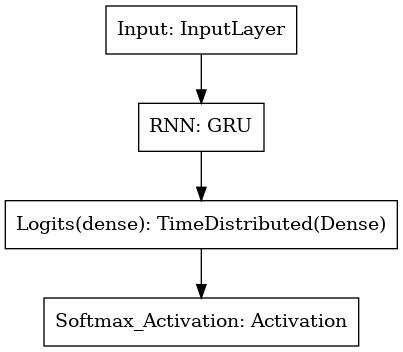

Training:   0%|           0/1 ETA: ?s,  ?epochs/s

Epoch 1/1


0/91           ETA: ?s - 

In [22]:
model = None
if TRAIN_GRU_MODEL:
    with runtime_context:
        # Clear GPU Memory
        tf.keras.backend.clear_session()

        # TODO: Preprocess and reshape the input to work with a basic RNN. (Hint: Use preproc_english_sentences, preproc_french_sentences and reshape function from keras)
        max_sentence_length = max([max_english_sequence_length, max_french_sequence_length])
        X_train = pad(preproc_english_sentences_train, max_sentence_length)
        X_train = X_train.reshape(-1, max_sentence_length, 1)
        y_true_train = pad(preproc_french_sentences_train, max_sentence_length)
        X_test = pad(preproc_english_sentences_test, max_sentence_length)
        X_test = X_test.reshape(-1, max_sentence_length, 1)
        y_true_test = pad(preproc_french_sentences_test, max_sentence_length)
        print(X_train.shape, y_true_train.shape, X_test.shape, y_true_test.shape)

        # TODO: Train the network you built in rnn_model. What size do you choose for the epochs, batch_size and validation_split?
        timestep = max_sentence_length
        features = 1  # observations at time
        model = gru_model(
            (timestep, features),
            timestep,
            english_vocab_size,
            french_vocab_size
        )

        # Train the model
        callbacks, timestamp_str = get_callbacks()
        history = model.fit(
            x=X_train,
            y=y_true_train,
            batch_size=batch_size,
            epochs=1,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=0
        )

In [23]:
if RUN_GRU_MODEL:
    gru_model = None
    if TRAIN_GRU_MODEL:
        # Save model
        if SAVE_GRU_MODEL:
            gru_model = model
            model.save(MODEL_DIR + model.name + "_" + timestamp_str + ".hd5")
    else:
        # Load model and set paras
        max_sentence_length = max([max_english_sequence_length, max_french_sequence_length])
        X_train = pad(preproc_english_sentences_train, max_sentence_length)
        X_train = X_train.reshape(-1, max_sentence_length, 1)
        y_true_train = pad(preproc_french_sentences_train, max_sentence_length)
        X_test = pad(preproc_english_sentences_test, max_sentence_length)
        X_test = X_test.reshape(-1, max_sentence_length, 1)
        y_true_test = pad(preproc_french_sentences_test, max_sentence_length)
        print(X_train.shape, y_true_train.shape, X_test.shape, y_true_test.shape)
        try:
            gru_model, model_name = model_load(MODEL_DIR, GRU_MODEL_FNAME)
            display(tf.keras.utils.plot_model(gru_model))
        except:
            print(f"Couldn't load model {GRU_MODEL_FNAME}")

    # TODO: Print prediction(s) for one or more of the English sentences. Hint: Make use of the `logits_to_text` function for transforming output logits to text. 
    # Check performance
    if gru_model != None:
        #print_predictions(gru_model, X_train)
        #print_performance(gru_model, X_test, y_true_test)
        pass

### Check model performance

In [24]:
print_predictions(model, X_test)


Orig. sentence:				paris is usually rainy during september but it is usually nice in january <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Orig. translation:			pluvieux enneigée les favori l' pamplemousse et les gèle <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model translation (prediction):		unis est est jamais en en mais est il il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Orig. sentence:				my favorite fruit is the pear but his favorite is the grapefruit <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Orig. translation:			les paris inde est jamais relaxant en avril et il est généralement juillet en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model translation (prediction):		unis préféré préféré est est la en mais mais est est parfois <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


#### Imported via metrics.py

In [25]:
def evaluate_external(y_true, y_pred, include_prediction=False):
    print(y_true)
    print(y_pred)
    id_to_prediction = {}
    id_to_references = {}

    id_to_prediction["1"] = y_pred
    id_to_references["1"] = [y_true]

    metrics = {}
    for metric in [met.BLEU(1), met.ROUGE()]:
        metric_name_to_value = metric.calculate(id_to_prediction, id_to_references)
        metrics.update(metric_name_to_value)
    return (metrics, id_to_prediction) if include_prediction else metrics

In [26]:
# Prepare data to check
pred = lambda x: x[0:1]
y_pred_train = model.predict(pred(X_train))
orig_sentence = fl_to_text(pred(X_train)[0], english_tokenizer)
orig_translat = fl_to_text(pred(y_true_train)[0], french_tokenizer)
pred_sentence = logits_to_text(y_pred_train[0], french_tokenizer)
print(f"\nOrig. sentence:\t\t\t\t{orig_sentence}")
print(f"Orig. translation:\t\t\t{orig_translat}")
print(f"Model translation (prediction):\t\t{pred_sentence}")


Orig. sentence:				he likes limes busy and grapes <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Orig. translation:			pluvieux enneigée les favori l' pamplemousse et les gèle <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Model translation (prediction):		pluvieux les les les les les les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [27]:
evaluate_external(
    orig_sentence,
    pred_sentence
)

he likes limes busy and grapes <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
pluvieux les les les les les les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


AttributeError: module 'src.models.metrics' has no attribute 'BLEU'

#### Own implementation (local)

In [28]:
import nltk.translate.bleu_score as ntbs
import rouge_score.rouge_scorer as rouge_scorer

def evaluate(c_true: dict, c_pred: dict, verbose:int = 0) -> tuple:
    """
    Calculate the performance of the model
    Metrics are: ROUGE-L and BLEU-1
    Arguments:
        c_true:  Dictionary containing all given captions per picture
                 key of the dictionary is the picture name
        c_pred:  Dictionary with one predicted caption per picture
                 key of the dictionary is the picture name
        verbose: Show insides regarding the verbose level
                 Levels:
                     0: show no insides
                     1: show ROUGE_L-Recall and BLEU-1-Precision lists
                     2: show internal data structures during run
                     3: show data inside loops
    Returns:
        ROUGE-L recall and BLEU-1 precision as float values within a tuple:
        Index:
            0: ROUGE-L recall
            1: BLEU-1 precision
    """
    # Init
    ROUGE_L_INDI = "rougeL"
    RECALL_INDEX = 1  # ROUGE-L score index
    WEIGTHS_1_GRAM = (1, 0, 0, 0)  # BLEU-1 config
    rouge_l_rec = []
    bleu_1_prec = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    crlf2 = lambda x: '\n' if x > 2 else ''

    # Calc scores
    for k in c_true.keys():
        references = c_true[k]
        if len(references) > 0:
            candidate = candidates[k]  # one per picture

            # Calc ROUGE-L recall and BLEU-1 references
            rrec = []  # ROUGE-L recalls temp
            bref = []  # BLEU-1 references temp
            for reference in references:
                # Calc ROUGE-L recall
                score = scorer.score(reference, candidate)[ROUGE_L_INDI][RECALL_INDEX]
                rrec.append(score)
                if verbose >= 3:
                    print(f"Rouge-L-Recall: pred. caption '{candidate}'\ttrue caption '{reference:<30}':\t{score}")

                # BLEU-1 reference transformation
                bref.append(reference.split(" "))

            # ROUGE-L max value selection
            r_score = max(rrec)
            rouge_l_rec.append(r_score)
            if verbose >= 2:
                print(f"Rouge-L-Recalls pred. caption '{candidate}': {rrec} -> {r_score}{crlf2(verbose)}")

            # Calc BlEU-1 precision
            b_score = ntbs.sentence_bleu(bref, candidate.split(" "), weights=WEIGTHS_1_GRAM)
            bleu_1_prec.append(b_score)
            if verbose >= 3:
                print(f"List of BLEU-1 true captions: {bref}")
            if verbose >= 2:
                print(f"BLEU-1-Precision pred. caption: '{candidate}': {b_score}\n")

        else:
            print("Reference caption for image {k} wrong")

    # Prepare results
    rouge_l_rec_score = sum(rouge_l_rec)/len(rouge_l_rec)
    bleu_1_prec_score = sum(bleu_1_prec)/len(bleu_1_prec)

    if verbose == 1:
        print(f"ROUGE-L-Recalls:\n{rouge_l_rec} -> {rouge_l_rec_score}")
        print(f"\nBLEU-1-Precisions:\n{bleu_1_prec} -> {bleu_1_prec_score}")

    return rouge_l_rec_score, bleu_1_prec_score


# Test it
references = dict({
    "picture1.jpg": ["police killed the gunman", "police kills the gunman", "police has killed the gunman"], 
    "picture2.jpg": ["girl is playing with a doll", "little girl holds a doll", "blond girl is playing"],
    "picture3.jpg": ["car is standing on a lot", "car before a building ", "car is parking near a house"]
})
candidates = dict({
    "picture1.jpg": "police kill the gunman",
    "picture2.jpg": "girl is playing",
    "picture3.jpg": "near a building car is waiting"
})
assert evaluate(references, candidates, verbose=0) == (0.6666666666666666, 0.7666215479690409)

In [29]:
# Prepare data
n_ds = 5
y_pred_train = model.predict(X_train[0:n_ds])
references = dict()
candidates = dict()
for i in range(n_ds):
    references[f"picture{i}.jpg"] = [fl_to_text(y_true_train[i], french_tokenizer)]
    candidates[f"picture{i}.jpg"] = logits_to_text(y_pred_train[i], french_tokenizer)
display(references, candidates)
print()

# Run evaluation
evaluate(references, candidates, verbose=1)

{'picture0.jpg': ["pluvieux enneigée les favori l' pamplemousse et les gèle <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"],
 'picture1.jpg': ['les paris inde est jamais relaxant en avril et il est généralement juillet en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture2.jpg': ['new est merveilleux au mois de hiver et il est jamais calme en printemps <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture3.jpg': ['unis états est jamais agréable en mars et il est jamais elle en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture4.jpg': ["la chaux est leur préféré fruit moins mais l' pamplemousse est chaud moins fruit <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"]}

{'picture0.jpg': 'pluvieux les les les les les les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture1.jpg': 'paris paris inde est est jamais en en mais il il il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture2.jpg': 'unis est en en en et est est il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture3.jpg': 'unis états est est jamais est en en est <PAD> il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture4.jpg': 'paris pendant est en préféré moins moins est est la en en mais il <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'}


ROUGE-L-Recalls:
[0.6521739130434783, 0.5652173913043478, 0.5238095238095238, 0.6363636363636364, 0.5652173913043478] -> 0.5885563711650668

BLEU-1-Precisions:
[0.7142857142857143, 0.6666666666666666, 0.5714285714285714, 0.7142857142857143, 0.6666666666666666] -> 0.6666666666666666


(0.5885563711650668, 0.6666666666666666)

#### Own implementation (metrics.py)

In [30]:
# Prepare data
n_ds = 5
y_pred_train = model.predict(X_train[0:n_ds])
references = dict()
candidates = dict()
for i in range(n_ds):
    references[f"picture{i}.jpg"] = [fl_to_text(y_true_train[i], french_tokenizer)]
    candidates[f"picture{i}.jpg"] = logits_to_text(y_pred_train[i], french_tokenizer)
display(references, candidates)
print()

# Run evaluation
met.evaluate(references, candidates, verbose=1)

{'picture0.jpg': ["pluvieux enneigée les favori l' pamplemousse et les gèle <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"],
 'picture1.jpg': ['les paris inde est jamais relaxant en avril et il est généralement juillet en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture2.jpg': ['new est merveilleux au mois de hiver et il est jamais calme en printemps <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture3.jpg': ['unis états est jamais agréable en mars et il est jamais elle en janvier <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'],
 'picture4.jpg': ["la chaux est leur préféré fruit moins mais l' pamplemousse est chaud moins fruit <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>"]}

{'picture0.jpg': 'pluvieux les les les les les les <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture1.jpg': 'paris paris inde est est jamais en en mais il il il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture2.jpg': 'unis est en en en et est est il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture3.jpg': 'unis états est est jamais est en en est <PAD> il parfois en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 'picture4.jpg': 'paris pendant est en préféré moins moins est est la en en mais il <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'}


ROUGE-L-Recalls:
[0.6521739130434783, 0.5652173913043478, 0.5238095238095238, 0.6363636363636364, 0.5652173913043478] -> 0.5885563711650668

BLEU-1-Precisions:
[0.7142857142857143, 0.6666666666666666, 0.5714285714285714, 0.7142857142857143, 0.6666666666666666] -> 0.6666666666666666


(0.5885563711650668, 0.6666666666666666)